In [3]:
import os
import time

from torchvision.transforms import v2
import torch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from PIL import Image
import tqdm.notebook as tqdm
from IPython import display
import gc 

%load_ext autoreload

from data_loaders import *
%autoreload 2
from training_utils import *
%autoreload 2
from cnn_model import *
%autoreload 2

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [4]:
def data_split(test_prop, batch_id, boundary_prop, test_module_ids, fold_idx, nfolds):
    assert 0 <= test_prop <= 1, 0 <= val_prop <= 1
    assert 0 <= fold_idx < nfolds, f'fold_idx was set to {fold_idx} but must be in the range [0, {nfolds - 1} = (nfolds - 1)]'
    batch_data = dsl[dsl['batch_id_x'] == batch_id]
    val_prop = 1 / nfolds
    
    if test_module_ids is not None:
        test_data = batch_data[batch_data['module_id'].isin(test_module_ids)].sort_values(by = 'frame_unix_t')
        train_data = batch_data[~batch_data['module_id'].isin(test_module_ids)].sort_values(by = 'frame_unix_t')
        assert len(test_data) > 0 and len(train_data) > 0, 'At least one module_id in test_modules={test_module_ids} is invalid.'        
        test_idx = test_data.index.values

        ntrain = len(train_data)
        nval = int(ntrain / nfolds)
        
        # nbdd = int((ntrain - nval) * boundary_prop / 2)
        left_val_idx = int(nval * fold_idx)
        right_val_idx = int(nval * (fold_idx + 1))
        
        val_idx = train_data[left_val_idx: right_val_idx].index.values
        
        train_idx = np.append(
            train_data[:left_val_idx].index.values,
            train_data[right_val_idx:].index.values
        )
    else:
        batch_data = batch_data.sort_values(by = 'frame_unix_t')
        test_split = int(len(batch_data) * test_prop)
        ntrain = len(batch_data) - test_split
        val_split = int(ntrain * val_prop)
        boundary_cnt = int((len(batch_data) - val_split) * boundary_prop)
        
        test_idx = batch_data[:test_split].index.values
        val_idx = batch_data[test_split: test_split + val_split].index.values
        train_idx = batch_data[test_split + val_split + boundary_cnt:].index.values
    assert len(set(val_idx).intersection(set(train_idx))) == 0, 'Must have non-empty intersection between val_idx and train_idx'
    assert len(set(train_idx).intersection(set(test_idx))) == 0, 'Must have non-empty intersection between train_idx and train_idx'
    assert len(set(val_idx).intersection(set(test_idx))) == 0, 'Must have non-empty intersection between val_idx and train_idx'

    return test_idx, val_idx, train_idx

def get_windowed_test_val_train_indices(test_prop, boundary_prop=0.2, test_module_ids=None, fold_idx=0, nfolds=5):
    test_indices = np.array([], dtype=np.int64)
    val_indices = np.array([], dtype=np.int64)
    train_indices = np.array([], dtype=np.int64)

    for batch_id in dsl['batch_id_x'].unique():
        test_idx, val_idx, train_idx = data_split(
            test_prop, batch_id, boundary_prop, test_module_ids, fold_idx, nfolds
        )
        test_indices = np.concatenate((test_indices, test_idx))
        val_indices = np.concatenate((val_indices, val_idx))
        train_indices = np.concatenate((train_indices, train_idx))
    return test_indices, val_indices, train_indices


def get_shuffled_test_val_train_indices(test_prop, val_prop):
    dataset_size = len(dsl)
    dataset_indices = np.arange(dataset_size)
    
    np.random.shuffle(dataset_indices)
    
    # Test / Train split
    test_split_index = int(np.floor(test_prop * dataset_size))
    trainset_indices, test_idx = dataset_indices[test_split_index:], dataset_indices[:test_split_index]
    
    # Train / Val split
    trainset_size = len(trainset_indices)
    val_split_index = int(np.floor(val_prop * trainset_size))
    train_idx, val_idx = trainset_indices[val_split_index:], trainset_indices[:val_split_index]
    return test_idx, val_idx, train_idx

def preview_frames(data_loader, frame_time=0.01):
    try:
        for X, Y in data_loader:
            for img in X:
                plt.imshow(img.reshape((32,32)), vmin=-2, vmax=2, cmap='icefire')
                plt.show()
                plt.close()
                time.sleep(frame_time)
                display.clear_output(wait=True)
    except KeyboardInterrupt:
        plt.close()
    finally:
        plt.close()
        gc.collect()

def print_class_dist(data, idx, name):
    filtered_data = data.iloc[idx]
    num_clear = len(filtered_data.loc[filtered_data['label'] == 'clear_night_sky'])
    num_cloudy = len(filtered_data.loc[filtered_data['label'] == 'not_clear_cloudy'])

    unique_module_ids = list(np.sort(filtered_data["module_id"].unique()))
    
    print(f'Percent cloudy (in {name}) = {100 *num_cloudy / len(filtered_data):.3f}% ({num_cloudy} / {len(filtered_data)}); '
          f'Unique module_ids: {unique_module_ids}')

In [5]:
# Creating the datasets

transform = v2.Compose([
    v2.ToTensor(),
    v2.RandomHorizontalFlip(),
    v2.RandomVerticalFlip(),
    # v2.RandomRotation(90, expand=False),
    v2.Normalize(mean=[0], std=[100]),
    # v2.Normalize(mean=[0, 150], std=[100, 100]),
    v2.ToDtype(torch.float, scale=True),
    # v2.ColorJitter(0.5, None, None, None),
    # v2.GaussianBlur(kernel_size=(5, 5), sigma=(0.2, 0.5))
])

target_transform = v2.Compose([
    v2.ToTensor(),
    v2.Normalize(mean=[0], std=[100]),
    # v2.Normalize(mean=[0, 150], std=[100, 100]),
    v2.ToDtype(torch.float, scale=True),
])


train_labeled_data = CloudDetectionTrain(
    transform=transform
)

test_labeled_data = CloudDetectionTrain(
    target_transform=target_transform
)

dsl = train_labeled_data.dsl_df
dataset_size = len(dsl)

In [6]:
test_prop = 0.3
nfolds = 5
boundary_prop = 0.1 # Proportion of data to discard between the validation and train_proportions (time)
batch_size = 64

In [7]:
test_idx, val_idx, train_idx = get_windowed_test_val_train_indices(
    test_prop, boundary_prop, test_module_ids=[3], fold_idx=0, nfolds=nfolds
)

# test_idx, val_idx, train_idx = get_shuffled_test_val_train_indices(test_prop, val_prop)
# print(test_idx, val_idx, train_idx)

test_loader = torch.utils.data.DataLoader(
  dataset=test_labeled_data,
  batch_size=batch_size,
  sampler=torch.utils.data.SubsetRandomSampler(test_idx)
)

train_loader = torch.utils.data.DataLoader(
  dataset=train_labeled_data,
  batch_size=batch_size,
  sampler=torch.utils.data.SubsetRandomSampler(train_idx)
)

val_loader = torch.utils.data.DataLoader(
  dataset=test_labeled_data,
  batch_size=batch_size,
  sampler=torch.utils.data.sampler.SubsetRandomSampler(val_idx)
)


# Get dataset stats

print(f'test_prop (of dataset) = {100 * len(test_idx) / dataset_size:.2f}%\n'
      f'train_prop (of trainset)= {100 * len(train_idx) / (len(val_idx) + len(train_idx)):.2f}%\n'
      f'val_prop (of trainset) = {100 * len(val_idx) / (len(val_idx) + len(train_idx)):.2f}%'
)
# feature_uid = train_labeled_data.dsl_df.loc[:, 'feature_uid'].iloc[0]
# train_labeled_data[0][0]


print_class_dist(dsl, test_idx, 'test')
print_class_dist(dsl, val_idx, 'val')
print_class_dist(dsl, train_idx, 'train')
print_class_dist(dsl, dsl.index, 'overall')
print(len(val_idx) / (len(val_idx) + len(train_idx)))
print(min(val_idx))

test_prop (of dataset) = 33.34%
train_prop (of trainset)= 80.07%
val_prop (of trainset) = 19.93%
Percent cloudy (in test) = 54.533% (1600 / 2934); Unique module_ids: [3]
Percent cloudy (in val) = 53.550% (626 / 1169); Unique module_ids: [1, 254]
Percent cloudy (in train) = 55.750% (2618 / 4696); Unique module_ids: [1, 254]
Percent cloudy (in overall) = 55.052% (4844 / 8799); Unique module_ids: [1, 3, 254]
0.19931798806479115
0


In [8]:
# preview_frames(train_loader, 0.1)

In [39]:
learning_rate = 0.001
weight_decay = 1e-5
epochs = 25
gamma = 0.9
def do_cross_validation(test_prop, nfolds):
    test_loader = None
    validation_accuracies = []
    trainers = []
    dsl = train_labeled_data.dsl_df
    try:
        print(nfolds)
        for fold_idx in range(nfolds):
            # Get data splits
            test_idx, val_idx, train_idx = get_windowed_test_val_train_indices(
                test_prop, boundary_prop, test_module_ids=[3], fold_idx=fold_idx, nfolds=nfolds
            )
            # Make dataloaders
            train_loader = torch.utils.data.DataLoader(
              dataset=train_labeled_data,
              batch_size=batch_size,
              sampler=torch.utils.data.SubsetRandomSampler(train_idx)
            )
            
            val_loader = torch.utils.data.DataLoader(
              dataset=test_labeled_data,
              batch_size=batch_size,
              sampler=torch.utils.data.sampler.SubsetRandomSampler(val_idx)
            )
            print(test_loader)
            if test_loader is None:
                test_loader = torch.utils.data.DataLoader(
                  dataset=test_labeled_data,
                  batch_size=batch_size,
                  sampler=torch.utils.data.SubsetRandomSampler(test_idx)
                )
                # Print stats
                print_class_dist(dsl, test_idx, 'test')
                print_class_dist(dsl, val_idx, 'val')
                print_class_dist(dsl, train_idx, 'train')
                print_class_dist(dsl, dsl.index, 'overall')

            # Create model
            model = CloudDetection()
            # optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-6)#, momentum=momentum)
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
            loss_fn = nn.CrossEntropyLoss()
            
            trainer = Trainer(
                model, optimizer, loss_fn, train_loader, val_loader,
                epochs=epochs, gamma=gamma, do_summary=False,
                # img_type=img_type
            )
            print(f'Doing Fold {fold_idx + 1} of {nfolds}')
            trainer.train(make_train_logs=False, write_plots=False)
            
            average_validation_accuracies_in_last_5_epochs = trainer.training_log['val']['acc'][-5:]
            validation_accuracies.append(average_validation_accuracies_in_last_5_epochs)
    
            # Cleanup
            trainer.model.to('cpu')
            trainers.append(trainer)
    finally:
        print(f'Average validation accuracy: {np.mean(validation_accuracies)}')
        return validation_accuracies, trainers

5
None
Percent cloudy (in test) = 54.533% (1600 / 2934); Unique module_ids: [3]
Percent cloudy (in val) = 53.550% (626 / 1169); Unique module_ids: [1, 254]
Percent cloudy (in train) = 55.750% (2618 / 4696); Unique module_ids: [1, 254]
Percent cloudy (in overall) = 55.052% (4844 / 8799); Unique module_ids: [1, 3, 254]
Doing Fold 1 of 5


Epoch 1


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.6898,  acc = 648/1169 (55.43%) 



Epoch 2


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.5966,  acc = 858/1169 (73.40%) 



Epoch 3


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.6228,  acc = 882/1169 (75.45%) 



Epoch 4


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.5674,  acc = 940/1169 (80.41%) 



Epoch 5


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.5593,  acc = 960/1169 (82.12%) 



Epoch 6


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.5116,  acc = 988/1169 (84.52%) 



Epoch 7


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.4675,  acc = 1035/1169 (88.54%) 



Epoch 8


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.4851,  acc = 1064/1169 (91.02%) 



Epoch 9


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.4671,  acc = 1047/1169 (89.56%) 



Epoch 10


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.4360,  acc = 1074/1169 (91.87%) 



Epoch 11


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.4696,  acc = 1062/1169 (90.85%) 



Epoch 12


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.4602,  acc = 1064/1169 (91.02%) 



Epoch 13


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.4511,  acc = 1096/1169 (93.76%) 



Epoch 14


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.4566,  acc = 1075/1169 (91.96%) 



Epoch 15


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.4488,  acc = 1089/1169 (93.16%) 



Epoch 16


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.4467,  acc = 1071/1169 (91.62%) 



Epoch 17


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.4268,  acc = 1105/1169 (94.53%) 



Epoch 18


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.4153,  acc = 1104/1169 (94.44%) 



Epoch 19


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.4287,  acc = 1085/1169 (92.81%) 



Epoch 20


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.3977,  acc = 1117/1169 (95.55%) 



Epoch 21


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.4056,  acc = 1101/1169 (94.18%) 



Epoch 22


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.4291,  acc = 1091/1169 (93.33%) 



Epoch 23


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.4276,  acc = 1085/1169 (92.81%) 



Epoch 24


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.4152,  acc = 1100/1169 (94.10%) 



Epoch 25


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.4133,  acc = 1097/1169 (93.84%) 

Done training


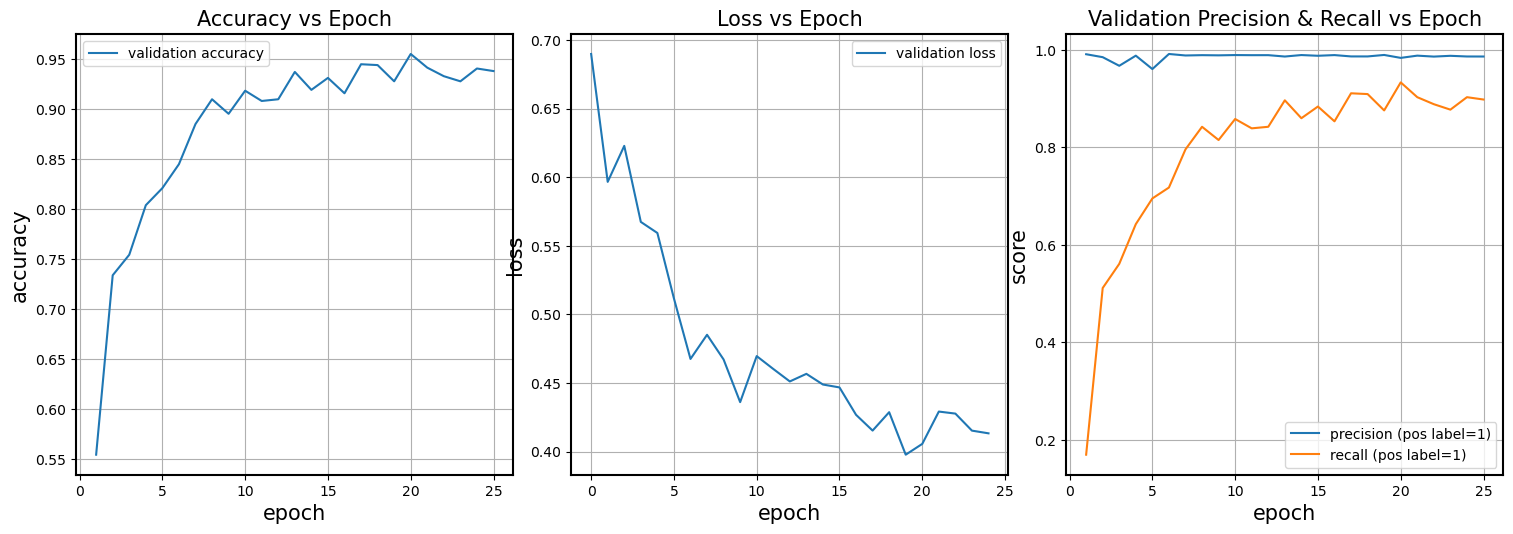

Doing Fold 2 of 5


Epoch 1


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.6913,  acc = 587/1169 (50.21%) 



Epoch 2


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.6644,  acc = 678/1169 (58.00%) 



Epoch 3


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.6093,  acc = 803/1169 (68.69%) 



Epoch 4


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.5777,  acc = 861/1169 (73.65%) 



Epoch 5


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.5346,  acc = 888/1169 (75.96%) 



Epoch 6


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.5039,  acc = 921/1169 (78.79%) 



Epoch 7


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.4820,  acc = 929/1169 (79.47%) 



Epoch 8


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.4812,  acc = 948/1169 (81.09%) 



Epoch 9


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.4917,  acc = 943/1169 (80.67%) 



Epoch 10


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.4832,  acc = 976/1169 (83.49%) 



Epoch 11


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.4723,  acc = 989/1169 (84.60%) 



Epoch 12


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.4858,  acc = 976/1169 (83.49%) 



Epoch 13


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.4713,  acc = 996/1169 (85.20%) 



Epoch 14


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.4860,  acc = 986/1169 (84.35%) 



Epoch 15


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.4786,  acc = 989/1169 (84.60%) 



Epoch 16


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.4739,  acc = 997/1169 (85.29%) 



Epoch 17


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.4754,  acc = 968/1169 (82.81%) 



Epoch 18


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.4618,  acc = 1015/1169 (86.83%) 



Epoch 19


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.4619,  acc = 988/1169 (84.52%) 



Epoch 20


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.4819,  acc = 983/1169 (84.09%) 



Epoch 21


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.4684,  acc = 1010/1169 (86.40%) 



Epoch 22


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.4494,  acc = 1005/1169 (85.97%) 



Epoch 23


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.4448,  acc = 1027/1169 (87.85%) 



Epoch 24


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.4611,  acc = 998/1169 (85.37%) 



Epoch 25


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.4667,  acc = 974/1169 (83.32%) 

Done training


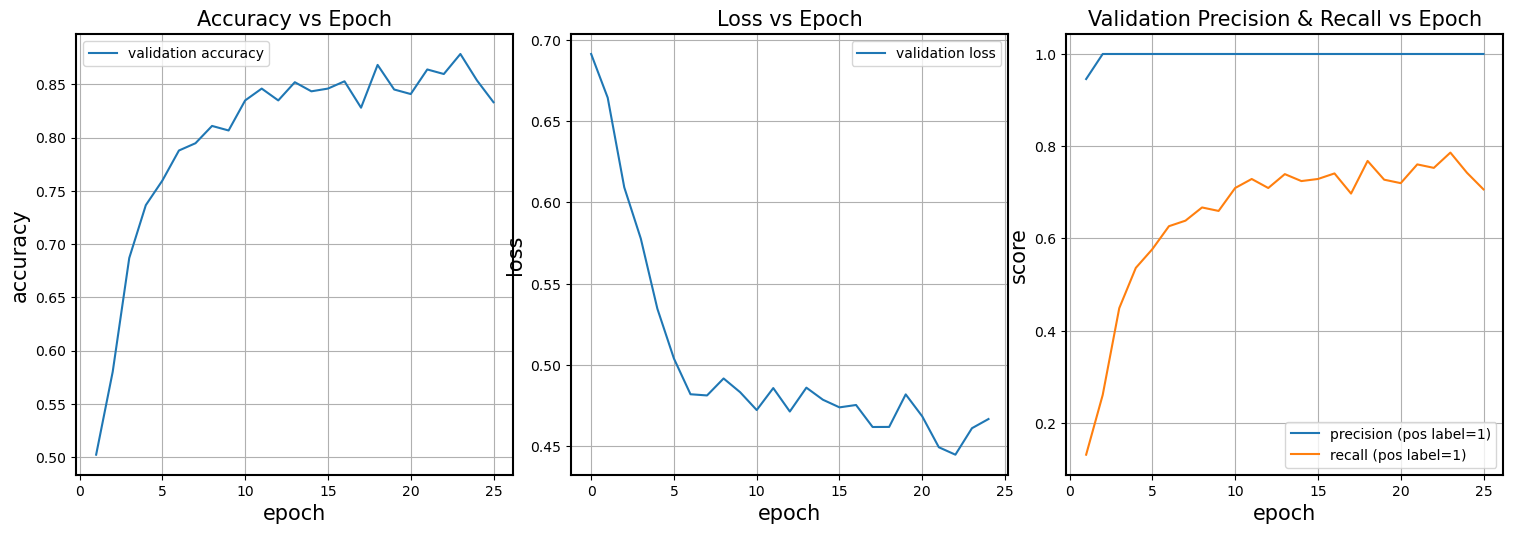

Doing Fold 3 of 5


Epoch 1


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.4712,  acc = 1117/1169 (95.55%) 



Epoch 2


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.4555,  acc = 1128/1169 (96.49%) 



Epoch 3


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.4202,  acc = 1129/1169 (96.58%) 



Epoch 4


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.3736,  acc = 1129/1169 (96.58%) 



Epoch 5


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.3556,  acc = 1128/1169 (96.49%) 



Epoch 6


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.3703,  acc = 1130/1169 (96.66%) 



Epoch 7


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.3711,  acc = 1129/1169 (96.58%) 



Epoch 8


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.3694,  acc = 1129/1169 (96.58%) 



Epoch 9


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.3463,  acc = 1130/1169 (96.66%) 



Epoch 10


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.3498,  acc = 1129/1169 (96.58%) 



Epoch 11


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.3280,  acc = 1129/1169 (96.58%) 



Epoch 12


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.3306,  acc = 1130/1169 (96.66%) 



Epoch 13


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.3296,  acc = 1131/1169 (96.75%) 



Epoch 14


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.3236,  acc = 1124/1169 (96.15%) 



Epoch 15


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.3290,  acc = 1127/1169 (96.41%) 



Epoch 16


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.3256,  acc = 1131/1169 (96.75%) 



Epoch 17


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.3320,  acc = 1129/1169 (96.58%) 



Epoch 18


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.3295,  acc = 1123/1169 (96.07%) 



Epoch 19


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.3331,  acc = 1129/1169 (96.58%) 



Epoch 20


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.3129,  acc = 1128/1169 (96.49%) 



Epoch 21


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.3121,  acc = 1131/1169 (96.75%) 



Epoch 22


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.3235,  acc = 1131/1169 (96.75%) 



Epoch 23


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.3200,  acc = 1128/1169 (96.49%) 



Epoch 24


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.3154,  acc = 1130/1169 (96.66%) 



Epoch 25


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.3200,  acc = 1129/1169 (96.58%) 

Done training


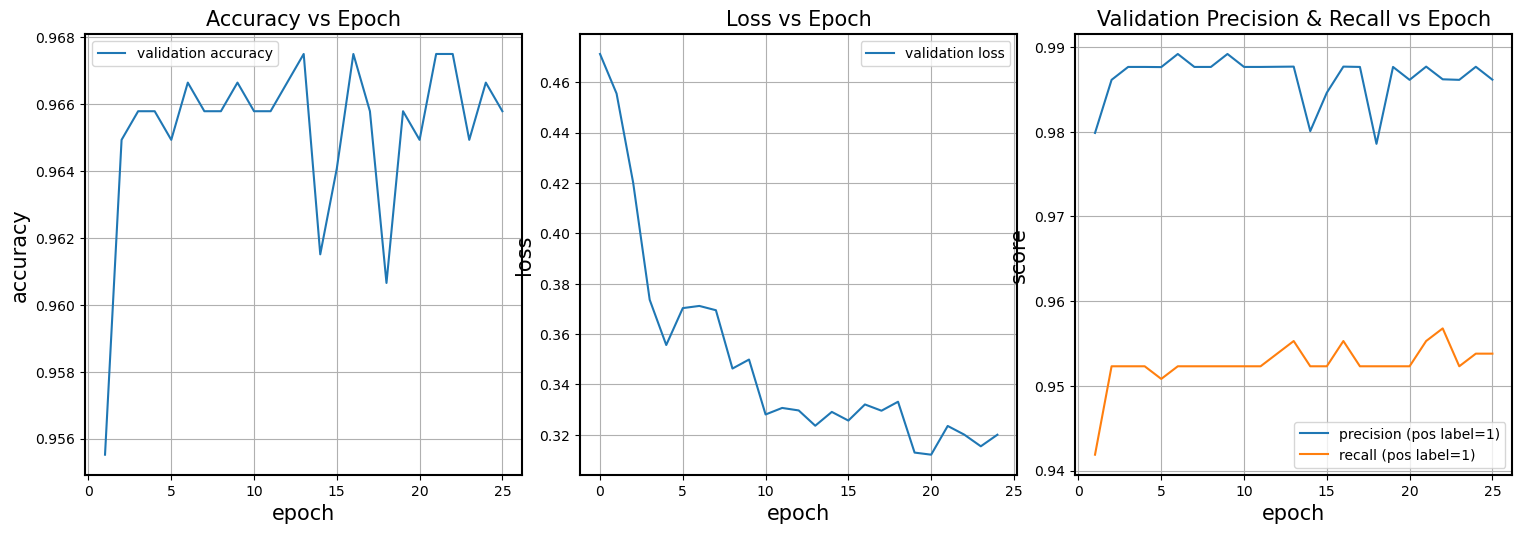

Doing Fold 4 of 5


Epoch 1


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.4919,  acc = 1053/1169 (90.08%) 



Epoch 2


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.4024,  acc = 1115/1169 (95.38%) 



Epoch 3


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.3731,  acc = 1112/1169 (95.12%) 



Epoch 4


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.3757,  acc = 1141/1169 (97.60%) 



Epoch 5


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.3525,  acc = 1141/1169 (97.60%) 



Epoch 6


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.3647,  acc = 1142/1169 (97.69%) 



Epoch 7


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.3738,  acc = 1140/1169 (97.52%) 



Epoch 8


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.3782,  acc = 1140/1169 (97.52%) 



Epoch 9


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.3319,  acc = 1141/1169 (97.60%) 



Epoch 10


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.3279,  acc = 1140/1169 (97.52%) 



Epoch 11


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.3435,  acc = 1141/1169 (97.60%) 



Epoch 12


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.3476,  acc = 1141/1169 (97.60%) 



Epoch 13


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.3480,  acc = 1142/1169 (97.69%) 



Epoch 14


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.3148,  acc = 1140/1169 (97.52%) 



Epoch 15


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.3362,  acc = 1139/1169 (97.43%) 



Epoch 16


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.3266,  acc = 1140/1169 (97.52%) 



Epoch 17


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.3399,  acc = 1140/1169 (97.52%) 



Epoch 18


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.3398,  acc = 1139/1169 (97.43%) 



Epoch 19


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.3414,  acc = 1141/1169 (97.60%) 



Epoch 20


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.3310,  acc = 1140/1169 (97.52%) 



Epoch 21


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.3403,  acc = 1140/1169 (97.52%) 



Epoch 22


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.3314,  acc = 1141/1169 (97.60%) 



Epoch 23


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.3288,  acc = 1141/1169 (97.60%) 



Epoch 24


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.3319,  acc = 1142/1169 (97.69%) 



Epoch 25


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.3282,  acc = 1140/1169 (97.52%) 

Done training


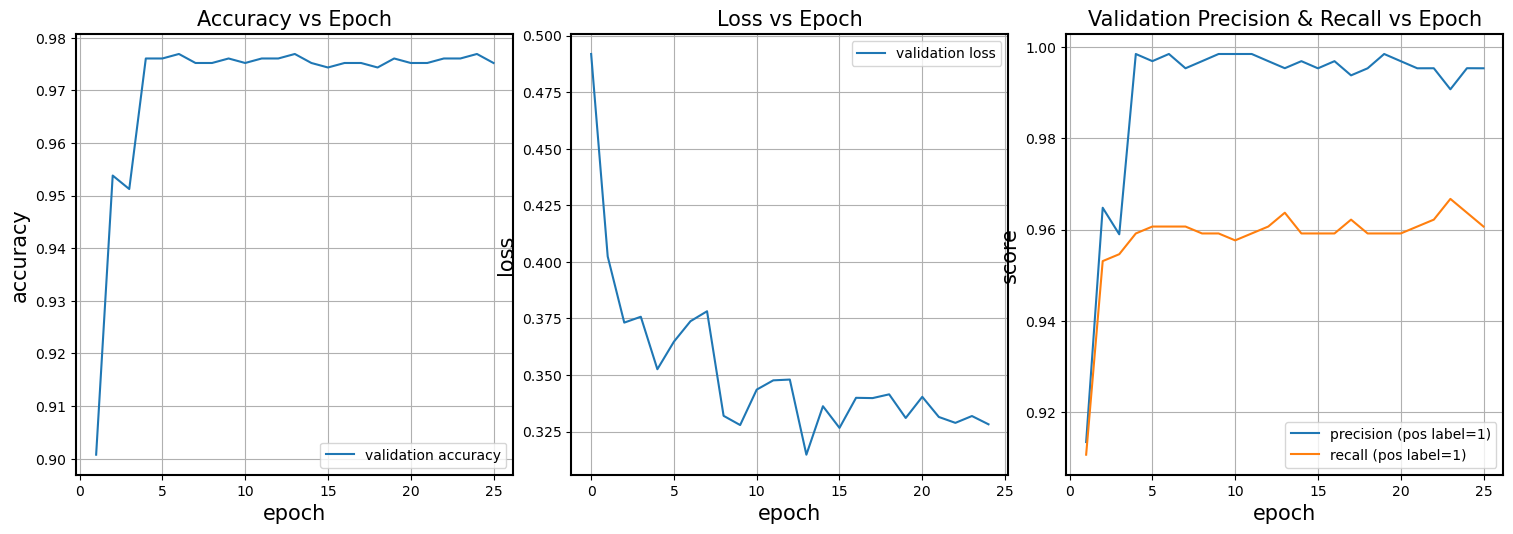

Doing Fold 5 of 5


Epoch 1


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.6155,  acc = 1092/1169 (93.41%) 



Epoch 2


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.5170,  acc = 1074/1169 (91.87%) 



Epoch 3


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.4692,  acc = 1123/1169 (96.07%) 



Epoch 4


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.4342,  acc = 1135/1169 (97.09%) 



Epoch 5


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.3987,  acc = 1132/1169 (96.83%) 



Epoch 6


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.4066,  acc = 1134/1169 (97.01%) 



Epoch 7


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.4380,  acc = 1131/1169 (96.75%) 



Epoch 8


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.4038,  acc = 1133/1169 (96.92%) 



Epoch 9


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.3732,  acc = 1136/1169 (97.18%) 



Epoch 10


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.3923,  acc = 1130/1169 (96.66%) 



Epoch 11


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.3725,  acc = 1129/1169 (96.58%) 



Epoch 12


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.3718,  acc = 1131/1169 (96.75%) 



Epoch 13


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.3873,  acc = 1131/1169 (96.75%) 



Epoch 14


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.3756,  acc = 1133/1169 (96.92%) 



Epoch 15


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.3718,  acc = 1129/1169 (96.58%) 



Epoch 16


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.3731,  acc = 1130/1169 (96.66%) 



Epoch 17


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.3701,  acc = 1132/1169 (96.83%) 



Epoch 18


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.3605,  acc = 1131/1169 (96.75%) 



Epoch 19


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.3696,  acc = 1133/1169 (96.92%) 



Epoch 20


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.3685,  acc = 1132/1169 (96.83%) 



Epoch 21


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.3627,  acc = 1133/1169 (96.92%) 



Epoch 22


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.3540,  acc = 1133/1169 (96.92%) 



Epoch 23


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.3505,  acc = 1131/1169 (96.75%) 



Epoch 24


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.3580,  acc = 1131/1169 (96.75%) 



Epoch 25


  0%|          | 0/74 [00:00<?, ?batches/s]

       Val: 	loss = 0.3596,  acc = 1131/1169 (96.75%) 

Done training


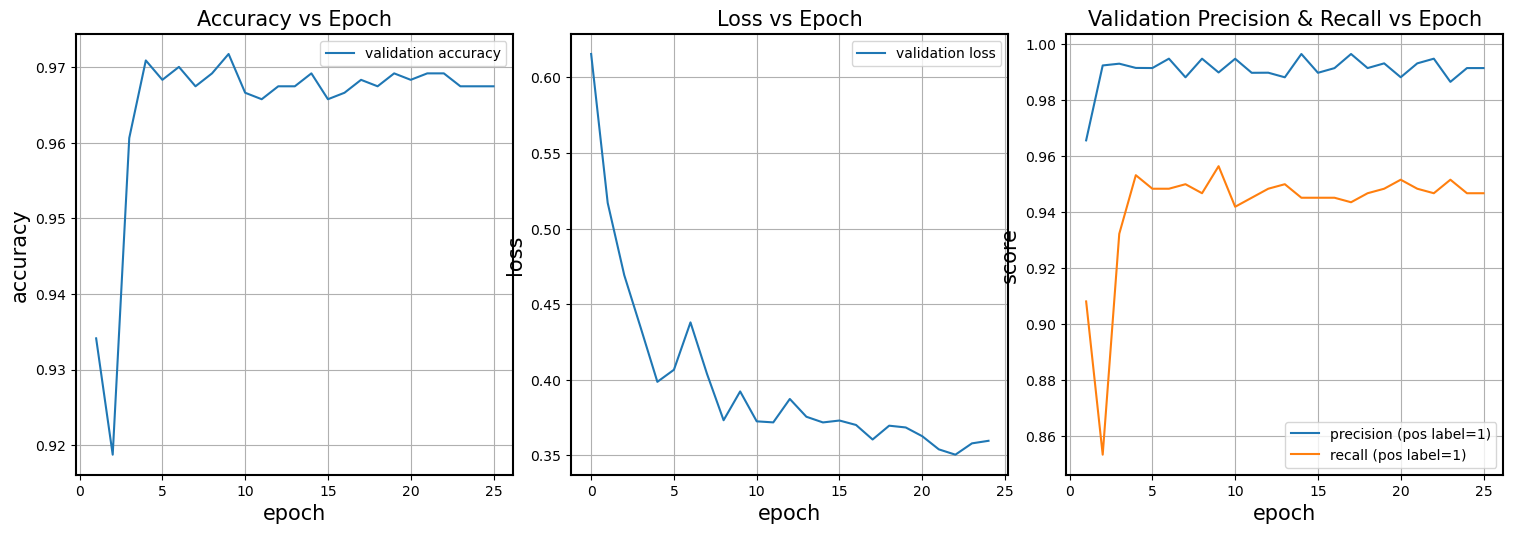

Average validation accuracy: 0.9409751924721984


In [40]:
validation_accuracies, trainers = do_cross_validation(test_prop, nfolds)

  0%|          | 0/46 [00:00<?, ?batches/s]

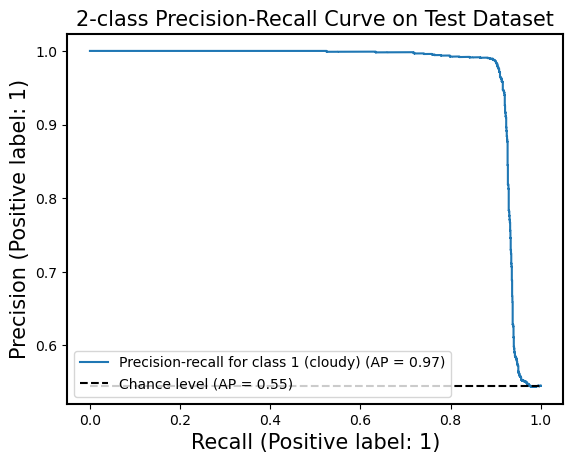

Test: 	loss = 0.3853,  acc = 2816/2934 (95.98%)


In [42]:
test_model = CloudDetection()
test_model.load_state_dict(torch.load('../model_training/best_cloud_detection_model.pth'))
loss_fn = nn.CrossEntropyLoss()
tester = Tester(test_model, loss_fn, test_loader)
tester.eval()

In [38]:
# Training config
learning_rate = 0.001
weight_decay = 1e-5
epochs = 20
gamma = 0.9
# momentum=0.9

model = CloudDetection()
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-6)#, momentum=momentum)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
loss_fn = nn.CrossEntropyLoss()


trainer = Trainer(
    model, optimizer, loss_fn, train_loader, val_loader,
    epochs=epochs, gamma=gamma, do_summary=True,
    # img_type=img_type
);
gc.collect();


Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 10, 10]          --
|    └─Conv2d: 2-1                       [-1, 64, 32, 32]          640
|    └─ReLU: 2-2                         [-1, 64, 32, 32]          --
|    └─BatchNorm2d: 2-3                  [-1, 64, 32, 32]          128
|    └─Dropout2d: 2-4                    [-1, 64, 32, 32]          --
|    └─Conv2d: 2-5                       [-1, 64, 32, 32]          36,928
|    └─ReLU: 2-6                         [-1, 64, 32, 32]          --
|    └─BatchNorm2d: 2-7                  [-1, 64, 32, 32]          128
|    └─Dropout2d: 2-8                    [-1, 64, 32, 32]          --
|    └─Conv2d: 2-9                       [-1, 64, 32, 32]          36,928
|    └─ReLU: 2-10                        [-1, 64, 32, 32]          --
|    └─BatchNorm2d: 2-11                 [-1, 64, 32, 32]          128
|    └─MaxPool2d: 2-12                   [-1, 64, 10, 10]          --
|  

In [ ]:
trainer.train(make_train_logs=False)

In [ ]:
tester = Tester(model, loss_fn, test_loader)
tester.eval()